In [1]:
# just makes the notebook full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import altair as alt
import pandas as pd
import glob
import json
import os
import numpy as np
import math

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [79]:
def load_json(fname):
    with open(fname, 'r') as f:
        contents = json.load(f)
    return contents


def load_evals(regex, basedir='../results/'):
    """Load evaluation results from TD3 methods, including all command-line flags."""
    job_dirs = glob.glob(os.path.join(basedir, regex))
    
    rows = []
    for job in job_dirs:
        try:
            options = load_json(job + '/opt.json')
            job_name = os.path.basename(os.path.normpath(job))
            results = np.load(os.path.join(job, 'eval.npy'))
            if len(results.shape) == 1:
                n = len(results)
                results = pd.DataFrame({'eval_step': np.linspace(1, n, n), 'mean_R': results})
            else:
                results = pd.DataFrame({'trajectories': results[:, 0], 'steps': results[:, 1], 'mean_R': results[:, 2]})
        except FileNotFoundError:
            results = None
            
        if results is not None:
            options = {key: str(value) for (key, value) in options.items()}
            results = results.assign(**options)
            rows.append(results)

    df = pd.concat(rows, sort=False)
    return df.reset_index(drop=True)


def load_baseline_data():
    """Load and clean up SAC and PPO results. Including this data makes plotting slow."""
    baseline_data = pd.concat([
        pd.read_pickle('sac_ppo_7dof_stats.pkl'),
        pd.read_pickle('sac_ppo_other_stats.pkl'),
    ], sort=False)
    split_names = baseline_data.name.str.split('_')
    baseline_data.name = split_names.str[0] + '_' + split_names.str[1] + '_seed' + split_names.str[2]
    baseline_data['seed'] = split_names.str[2].astype(int)
    baseline_data['steps'] = baseline_data['step']
    return baseline_data



def drop_short_groups(df, groups, within=None, threshold_rel=1.0, threshold_abs=0):
    """Drop bins of the data that don't include enough datapoints. 
    Prevents the last point in each plot from wiggling around so much due to small sample size.
    """
    
    df = df.copy()
    if within is not None:
        within_values = df[within].unique()
        for within_value in within_values:
            grouped_df = df[df[within] == within_value].groupby(groups)
            max_len = 0
            for group in grouped_df.groups:
                max_len = max(max_len, len(grouped_df.get_group(group).index))
            for group in grouped_df.groups:
                index = grouped_df.get_group(group).index
                if len(index) < threshold_rel * max_len - threshold_abs:
                    df = df.drop(index)
    else:
        grouped_df = df.groupby(groups)
        max_len = 0
        for group in grouped_df.groups:
            max_len = max(max_len, len(grouped_df.get_group(group).index))
        for group in grouped_df.groups:
            index = grouped_df.get_group(group).index
            if len(index) < threshold_rel * max_len - threshold_abs:
                df = df.drop(index)
    return df


def cut(df, column, bins, groups=['name'], y_axis='mean_R', drop_short=True):
    """Bin the data, optionally dropping bins that are not yet full."""
    binned_column = 'binned_' + column
    left_column = 'left_' + column
    right_column = 'right_' + column

    df = df.dropna(subset=[y_axis])
    df[binned_column] = pd.cut(df[column], bins)
    df[left_column] = df[binned_column].apply(lambda d: d.left)
    df[right_column] = df[binned_column].apply(lambda d: d.right)
    df = df.drop(binned_column, axis=1)
    if drop_short:
        df = drop_short_groups(df, ['name', left_column, right_column], threshold_abs=1)

    df = df.groupby(list({'name', 'seed', left_column, right_column, *groups}), as_index=False).mean()

    return df.dropna(subset=[y_axis])


def summarize_series(df, x_axis, bins=50, groups=['name'], y_axis='mean_R', 
                     collect_seeds=False, drop_short_bins=False, drop_short_seeds=False):
    """Bin and average the data."""
    df = df.copy()
    df = df.dropna(subset=[y_axis])
    groups = [group for group in groups if group != y_axis]
    df = cut(df, x_axis, bins, groups=groups, y_axis=y_axis, drop_short=drop_short_bins)
    if collect_seeds:
        df = seed_stats(df, groups=['left_' + x_axis, 'name'], y_axis=y_axis, drop_short=drop_short_seeds)
    else:
        df['seed_count'] = 1
        for transform in ['mean', 'min', 'max', 'median']:
            df[transform + '_' + y_axis] = df[y_axis]
    return df

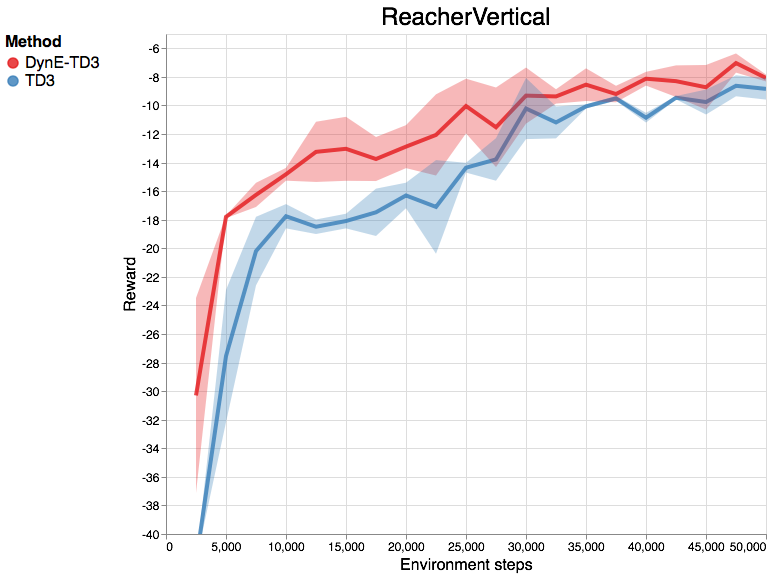

In [100]:
color = 'policy_name'
y = 'mean_R'
x = 'steps'

# load all the experiments to plot
all_data = pd.concat([
    # `name` of your experiment (will be expanded by glob.glob, should end in "_seedN")
    load_evals('ReacherVertical-v2*', basedir='./rl/results/'),
    
    # uncomment me to include SAC and PPO (may be slow)
    # load_baseline_data(),
], sort=False)

# specify the environments to plot results for and the plot ranges
experiments = [

    # format: (env name or substring, max steps to plot, [ymin, ymax])
    
    ('ReacherVertical', 5e4, [-20, -5]), 
#     ('ReacherTurn', 1e6, [-210, -75]), 
#     ('ReacherPush', 2e6, [-200, -60]),

#     ('Pusher', 2e6, [-60, -20]), 
#     ('Striker', 4e6, [-350, -130]), 
#     ('Thrower', 5e6, [-800, -40]),
]

charts = []
for i, (env, xmax, yrange) in enumerate(experiments):
    data = all_data[all_data.env_name.str.contains(env)]
    data = data[(data[x] <= xmax)]

    # perform smoothing on each experiment + seed separately by binning evaluations
    data = summarize_series(data, x, bins=20, groups=list({'name', color}))
    data.name = data.name.str.replace('_seed\d', '')
    
    # plot as a solid line the mean score over seeds
    collected_y = 'mean({})'.format(y)
    base_chart = alt.Chart(data, title='{}'.format(env)).mark_line(opacity=0.8, strokeWidth=4).encode(
        x=alt.X(f'right_{x}:Q', scale=alt.Scale(domain=[0, xmax]), title="Environment steps"),
        y=alt.Y(collected_y + ':Q', scale=alt.Scale(domain=yrange), title=("Reward" if i == 0 else "")),
        detail='name',
        color=alt.Color(color + ':N', legend=alt.Legend(title='Method', orient='left', offset=20), scale=alt.Scale(scheme='set1')))
    

    # plot a confidence interval expressing the uncertainty over random initializations
    ci = base_chart.mark_area(opacity=0.3).encode(
        y=alt.Y('ci0({})'.format(y), scale=scale),
        y2=alt.Y2('ci1({})'.format(y)),
    )

    # add nice tooltips on hover
    tooltips = base_chart.mark_circle(opacity=0, size=120).encode(tooltip=['name', 'policy_name', 'right_steps', collected_y])

    
    chart = base_chart + ci + tooltips
    chart = chart.interactive().properties(width=600, height=500)
    charts.append(chart)
    
chart = alt.hconcat(*charts, spacing=30)
chart = chart.configure(
    title=alt.TitleConfig(fontSize=24, fontWeight='normal'),
    axis=alt.AxisConfig(titleFontSize=16, labelFontSize=12, titleFontWeight='normal'),
    legend=alt.LegendConfig(titleFontSize=16, labelFontSize=16, fillColor='white', labelLimit=600)
)

chart